In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from util import stopwatch, get_stopwatch
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

save_img_row_size = 8
label_list = "plane autos birds cats_ deer_ dogs_ frogs horse ships truck".split(" ")
def save_labels(labels, path):
    with open(path, 'w') as f:
        for i, label in enumerate(labels.detach().numpy()):
            l = np.where(label==1)[0][0]
            print(label_list[l], file=f, end=('\n' if (i+1) % save_img_row_size == 0 else ' '))
torch.manual_seed(7)

## TODO Try auxiliary task of determining class as way of improving generation
Also try CIFAR100 with word embeddings

In [2]:
num_epochs = 1000
batch_size = 100
sample_dir = 'samples_dc_cond_cifar_finer3'
num_labels = 10

if not os.path.exists(sample_dir): os.makedirs(sample_dir)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])
def denorm(x): return ((x+1)/2).clamp(0,1)

def one_hot(x):
    r = torch.zeros(num_labels)
    try: r[x] = 1
    except: r[x.item()] = 1
    return r
dataset = torchvision.datasets.CIFAR10(root='~/cifar10-data/', train=True, download=True,
                                   transform=transform, target_transform=one_hot)

data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size = batch_size, shuffle=True)

Files already downloaded and verified


In [3]:
from matplotlib import pyplot as plt
show_i = 4
print("{} images of {}".format(len(dataset), dataset[1][0].shape))
print(dataset[show_i][1])
print(dataset[show_i][0].shape)
plt.imshow(denorm(dataset[show_i][0].permute(1,2,0)))

50000 images of torch.Size([3, 32, 32])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([3, 32, 32])


In [4]:
latent_size = 64
image_size = 32 * 32
num_colors = 3
num_kernels = 32

D = nn.Sequential(
    # add label to each pixel in input. (10+3) * 32 * 32
    nn.Conv2d(num_labels+num_colors, num_kernels, 2, 2, 0),
    # 32x16x16
    nn.LeakyReLU(0.2),
    nn.Conv2d(num_kernels, num_kernels*2, 3, 2, 1),
    # 64x8x8
    nn.BatchNorm2d(num_kernels * 2),
    nn.LeakyReLU(0.2),
    nn.Conv2d(num_kernels*2, num_kernels*4, 2, 1),
    # 128x7x7
    nn.BatchNorm2d(num_kernels * 4),
    nn.LeakyReLU(0.2),
    nn.Conv2d(num_kernels*4, num_kernels*8, 2, 2),
    # 256x3x3
    nn.BatchNorm2d(num_kernels * 8),
    nn.LeakyReLU(0.2),
    nn.Conv2d(num_kernels*8, 1, 3),
    nn.Sigmoid())
D = D.to(device)
D_losses = []

G = nn.Sequential(
    nn.ConvTranspose2d(latent_size+num_labels, num_kernels*8, 3, 1, 0),
    # 256x3x3
    nn.BatchNorm2d(num_kernels*8),
    nn.ReLU(),
    nn.ConvTranspose2d(num_kernels*8, num_kernels*4, 2, 2, 1),
    # 128x5x5
    nn.BatchNorm2d(num_kernels*4),
    nn.ReLU(),
    nn.ConvTranspose2d(num_kernels*4, num_kernels*2, 2, 2, 0, 1),
    # 64x9x9
    nn.BatchNorm2d(num_kernels*2),
    nn.ReLU(),
    nn.ConvTranspose2d(num_kernels*2, num_kernels*3//2, 3, 2, 1),
    nn.BatchNorm2d(num_kernels*3//2),
    nn.ReLU(),
    nn.ConvTranspose2d(num_kernels*3//2, num_kernels, 2, 1, 1),
    # 32x16x16
    nn.BatchNorm2d(num_kernels),
    nn.ReLU(),
    nn.ConvTranspose2d(num_kernels, num_colors, 2, 2, 0),
    nn.Tanh())
#print(G(torch.zeros(1,74,1,1)).shape)
G = G.to(device)
G_losses = []

In [5]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def reset_grad(): d_optimizer.zero_grad(); g_optimizer.zero_grad()

In [120]:
import pickle as pkl

total_step = len(data_loader)
for epoch in range(num_epochs):
    stopwatch()
    pkl.dump({'D_losses': D_losses, 'G_losses': G_losses}, open(os.path.join(sample_dir, 'losses.pkl'), 'wb'))
    D_loss_this_epoch = []
    G_loss_this_epoch = []
    D_losses.append(D_loss_this_epoch)
    G_losses.append(G_loss_this_epoch)
    G.train()
    D.train()
    
    for i, (images, labels_cpu) in enumerate(data_loader):
        real_labels = torch.ones (batch_size, 1, 1, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1, 1, 1).to(device)
        labels = labels_cpu.to(device)
        
        ## discriminator
        # input real images to discriminator
        images = images.to(device)
        # expand batch_size * 10 to batch_size * 10 * image_width * image_height
        labels_dups = labels.unsqueeze(dim=-1).unsqueeze(dim=-1).expand(labels.shape+images.shape[2:])
        d_inputs = torch.cat((images, labels_dups), 1)
        
        # compute loss on real images
        outputs = D(d_inputs)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # generate fake images
        z = torch.randn(batch_size, latent_size).to(device)
        g_inputs = torch.cat((z, labels), 1) # batch_size * latent_dim
        g_inputs = g_inputs.unsqueeze(-1).unsqueeze(-1) # -> batch_size * latent_dim * 1 * 1 for DC generator
        fake_images = G(g_inputs)
        
        # input fake images to discriminator
        d_inputs = torch.cat((fake_images, labels_dups), 1)
        outputs = D(d_inputs)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # compute total loss and backprop
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        ## generator
        # generate fake images
        z = torch.randn(batch_size, latent_size).to(device)
        g_inputs = torch.cat((z, labels), 1).unsqueeze(-1).unsqueeze(-1)
        fake_images = G(g_inputs)
        
        # feed to discriminator
        d_inputs = torch.cat((fake_images, labels_dups), 1)
        outputs = D(d_inputs)
        
        # compute loss for generator and backprop
        g_loss = criterion(outputs, real_labels)
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 25 == 0:
            # only gets a subsample of the losses but that's okay
            D_loss_this_epoch.append(d_loss.item())
            G_loss_this_epoch.append(g_loss.item())
            t = get_stopwatch()
            print('Epoch [{}/{}], [{}/{}] ({:.1f}s/{:.1f}s) dl({:.4f}) gl({:.4f}), D(x)={:.2f}, D(G(z))={:.2f}'
                  .format(epoch, num_epochs, i+1, total_step,
                          t, t*total_step/i,
                          d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()), end="\r")
    print("")
    if epoch == 0: save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    save_labels(labels_cpu, os.path.join(sample_dir, 'fake_labels-{}.txt'.format(epoch+1)))
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    
    if (epoch+1) % 20 == 0:
        torch.save(G.state_dict(), os.path.join(sample_dir, 'G_cond_{}.ckpt'.format(epoch)))
        torch.save(D.state_dict(), os.path.join(sample_dir, 'D_cond_{}.ckpt'.format(epoch)))


Epoch [0/1000], [500/500] (38.9s/39.0s) dl(0.2308) gl(3.3079), D(x)=0.93, D(G(z))=0.13
Epoch [1/1000], [500/500] (39.2s/39.3s) dl(0.6610) gl(2.1309), D(x)=0.77, D(G(z))=0.23
Epoch [2/1000], [500/500] (38.9s/39.0s) dl(0.1072) gl(4.5747), D(x)=0.94, D(G(z))=0.03
Epoch [3/1000], [500/500] (39.0s/39.1s) dl(0.1293) gl(4.5393), D(x)=0.98, D(G(z))=0.08
Epoch [4/1000], [500/500] (39.6s/39.7s) dl(0.1676) gl(2.1900), D(x)=0.97, D(G(z))=0.11
Epoch [5/1000], [500/500] (39.6s/39.7s) dl(0.2667) gl(4.2443), D(x)=0.87, D(G(z))=0.05
Epoch [6/1000], [500/500] (38.6s/38.7s) dl(0.1149) gl(4.5575), D(x)=0.97, D(G(z))=0.06
Epoch [7/1000], [500/500] (38.7s/38.7s) dl(0.2629) gl(2.9234), D(x)=0.91, D(G(z))=0.11
Epoch [8/1000], [500/500] (38.7s/38.8s) dl(0.1864) gl(3.2955), D(x)=0.92, D(G(z))=0.06
Epoch [9/1000], [500/500] (38.7s/38.8s) dl(0.0849) gl(5.0351), D(x)=0.94, D(G(z))=0.01
Epoch [10/1000], [500/500] (38.7s/38.8s) dl(0.1073) gl(4.3759), D(x)=0.96, D(G(z))=0.05
Epoch [11/1000], [500/500] (38.9s/39.0s) d

Epoch [187/1000], [500/500] (39.1s/39.2s) dl(0.3364) gl(3.0806), D(x)=0.97, D(G(z))=0.20
Epoch [188/1000], [500/500] (38.7s/38.7s) dl(0.1888) gl(3.2996), D(x)=0.94, D(G(z))=0.09
Epoch [189/1000], [500/500] (38.6s/38.7s) dl(0.2633) gl(2.8770), D(x)=0.91, D(G(z))=0.11
Epoch [190/1000], [500/500] (39.0s/39.1s) dl(0.1459) gl(5.2744), D(x)=0.92, D(G(z))=0.04
Epoch [191/1000], [500/500] (39.5s/39.5s) dl(0.2571) gl(2.1272), D(x)=0.92, D(G(z))=0.11
Epoch [192/1000], [500/500] (39.3s/39.3s) dl(0.1239) gl(4.2782), D(x)=0.92, D(G(z))=0.03
Epoch [193/1000], [500/500] (39.7s/39.7s) dl(0.1468) gl(3.4085), D(x)=0.98, D(G(z))=0.10
Epoch [194/1000], [500/500] (39.5s/39.6s) dl(0.1053) gl(4.3934), D(x)=0.95, D(G(z))=0.03
Epoch [195/1000], [500/500] (39.7s/39.8s) dl(0.1451) gl(4.4666), D(x)=0.91, D(G(z))=0.03
Epoch [196/1000], [500/500] (38.6s/38.7s) dl(0.1206) gl(4.0537), D(x)=0.96, D(G(z))=0.06
Epoch [197/1000], [500/500] (39.5s/39.6s) dl(0.3423) gl(4.5126), D(x)=0.95, D(G(z))=0.19
Epoch [198/1000], [50

Epoch [371/1000], [500/500] (38.6s/38.7s) dl(0.2284) gl(3.3642), D(x)=0.95, D(G(z))=0.10
Epoch [372/1000], [500/500] (38.6s/38.7s) dl(0.4994) gl(4.8187), D(x)=0.73, D(G(z))=0.04
Epoch [373/1000], [500/500] (38.7s/38.8s) dl(0.1814) gl(3.7758), D(x)=0.98, D(G(z))=0.11
Epoch [374/1000], [500/500] (38.7s/38.7s) dl(0.2473) gl(2.5837), D(x)=0.95, D(G(z))=0.13
Epoch [375/1000], [500/500] (38.7s/38.8s) dl(0.1165) gl(2.5181), D(x)=0.97, D(G(z))=0.08
Epoch [376/1000], [500/500] (38.7s/38.8s) dl(0.6954) gl(3.1544), D(x)=0.99, D(G(z))=0.38
Epoch [377/1000], [500/500] (38.7s/38.8s) dl(0.0846) gl(3.1459), D(x)=0.95, D(G(z))=0.03
Epoch [378/1000], [500/500] (38.6s/38.7s) dl(0.1734) gl(4.7724), D(x)=0.88, D(G(z))=0.02
Epoch [379/1000], [500/500] (38.6s/38.7s) dl(0.0588) gl(4.0973), D(x)=0.98, D(G(z))=0.03
Epoch [380/1000], [500/500] (38.6s/38.7s) dl(0.1949) gl(3.1715), D(x)=0.95, D(G(z))=0.10
Epoch [381/1000], [500/500] (38.6s/38.7s) dl(0.1240) gl(5.0211), D(x)=0.92, D(G(z))=0.02
Epoch [382/1000], [50

Epoch [555/1000], [500/500] (38.7s/38.8s) dl(0.3313) gl(5.0485), D(x)=0.84, D(G(z))=0.04
Epoch [556/1000], [500/500] (38.8s/38.9s) dl(0.2129) gl(3.0163), D(x)=0.92, D(G(z))=0.08
Epoch [557/1000], [500/500] (38.8s/38.8s) dl(0.1627) gl(2.9774), D(x)=0.96, D(G(z))=0.10
Epoch [558/1000], [500/500] (38.9s/39.0s) dl(0.1268) gl(3.0003), D(x)=0.97, D(G(z))=0.07
Epoch [559/1000], [500/500] (38.7s/38.8s) dl(0.1058) gl(6.9369), D(x)=0.94, D(G(z))=0.02
Epoch [560/1000], [500/500] (38.7s/38.7s) dl(0.9913) gl(2.0504), D(x)=0.90, D(G(z))=0.45
Epoch [561/1000], [500/500] (38.7s/38.8s) dl(0.3081) gl(2.6338), D(x)=0.93, D(G(z))=0.16
Epoch [562/1000], [500/500] (38.7s/38.8s) dl(0.2766) gl(3.3000), D(x)=0.84, D(G(z))=0.04
Epoch [563/1000], [500/500] (38.7s/38.8s) dl(0.1530) gl(4.8013), D(x)=0.99, D(G(z))=0.10
Epoch [564/1000], [500/500] (38.8s/38.9s) dl(0.3729) gl(3.3946), D(x)=0.98, D(G(z))=0.23
Epoch [565/1000], [500/500] (38.6s/38.7s) dl(0.3265) gl(2.3340), D(x)=0.85, D(G(z))=0.08
Epoch [566/1000], [50

Epoch [739/1000], [500/500] (39.6s/39.6s) dl(0.4072) gl(4.1141), D(x)=0.75, D(G(z))=0.02
Epoch [740/1000], [500/500] (39.4s/39.5s) dl(0.2649) gl(3.6616), D(x)=0.91, D(G(z))=0.11
Epoch [741/1000], [500/500] (39.3s/39.4s) dl(0.3353) gl(3.8371), D(x)=0.91, D(G(z))=0.16
Epoch [742/1000], [500/500] (39.6s/39.7s) dl(0.1559) gl(2.6525), D(x)=0.93, D(G(z))=0.06
Epoch [743/1000], [500/500] (39.4s/39.5s) dl(0.3585) gl(2.9186), D(x)=0.88, D(G(z))=0.12
Epoch [744/1000], [500/500] (39.5s/39.5s) dl(0.1580) gl(6.5620), D(x)=0.90, D(G(z))=0.02
Epoch [745/1000], [500/500] (39.3s/39.4s) dl(0.1789) gl(2.8838), D(x)=0.97, D(G(z))=0.11
Epoch [746/1000], [500/500] (39.5s/39.6s) dl(0.1681) gl(2.4617), D(x)=0.93, D(G(z))=0.06
Epoch [747/1000], [500/500] (39.5s/39.6s) dl(0.2408) gl(4.2462), D(x)=0.86, D(G(z))=0.03
Epoch [748/1000], [500/500] (39.2s/39.3s) dl(0.2842) gl(4.5591), D(x)=0.82, D(G(z))=0.02
Epoch [749/1000], [500/500] (39.4s/39.5s) dl(0.1530) gl(5.8606), D(x)=0.96, D(G(z))=0.06
Epoch [750/1000], [50

Epoch [925/1000], [500/500] (39.2s/39.2s) dl(0.1640) gl(4.1011), D(x)=0.92, D(G(z))=0.06
Epoch [926/1000], [500/500] (38.9s/39.0s) dl(0.3350) gl(3.0339), D(x)=0.82, D(G(z))=0.04
Epoch [927/1000], [500/500] (39.3s/39.4s) dl(0.2160) gl(2.9568), D(x)=0.91, D(G(z))=0.08
Epoch [928/1000], [500/500] (39.3s/39.4s) dl(0.0588) gl(3.4886), D(x)=0.99, D(G(z))=0.05
Epoch [929/1000], [500/500] (39.4s/39.5s) dl(0.1470) gl(5.6638), D(x)=0.92, D(G(z))=0.05
Epoch [930/1000], [500/500] (39.4s/39.5s) dl(0.2310) gl(4.6461), D(x)=0.95, D(G(z))=0.13
Epoch [931/1000], [500/500] (39.3s/39.4s) dl(0.0790) gl(3.3902), D(x)=0.99, D(G(z))=0.05
Epoch [932/1000], [500/500] (39.2s/39.3s) dl(0.0873) gl(2.9377), D(x)=0.99, D(G(z))=0.06
Epoch [933/1000], [500/500] (39.2s/39.3s) dl(0.2688) gl(5.1723), D(x)=0.95, D(G(z))=0.13
Epoch [934/1000], [500/500] (39.4s/39.5s) dl(0.1455) gl(5.6412), D(x)=0.93, D(G(z))=0.05
Epoch [935/1000], [500/500] (39.3s/39.4s) dl(0.3832) gl(4.6853), D(x)=0.91, D(G(z))=0.17
Epoch [936/1000], [50

In [40]:
torch.save(G.state_dict(), os.path.join(sample_dir, 'G_cond_{}.ckpt'.format(epoch)))
torch.save(D.state_dict(), os.path.join(sample_dir, 'D_cond_{}.ckpt'.format(epoch)))

In [121]:
# [(image, [nearest_neighbours]), ...]
def generate_images(G, category, num):
    G.eval()
    z = torch.randn(num, latent_size).to(device)
    # get num x num_labels matrix of one-hot vectors indicating the category
    labels = torch.zeros(num_labels)
    labels[category] = 1
    labels = labels.unsqueeze(0).expand(num, num_labels).to(device)
    g_inputs = torch.cat((z, labels), 1) # num * latent_dim
    g_inputs = g_inputs.unsqueeze(-1).unsqueeze(-1) # -> num * latent_dim * 1 * 1 for DC generator
    fake_images = G(g_inputs)
    return denorm(fake_images).detach()

ships


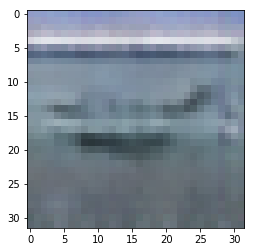

In [168]:
category = 8
print(label_list[category])
imgs = generate_images(G, category, 10)
plt.imshow(imgs[1].cpu().permute(1,2,0).numpy())

In [8]:
def one_hot_multi(x):
    r = torch.zeros([x.shape[0], num_labels] + list(x.shape[2:])).to(device)
    r.scatter_(1, x.unsqueeze(1), 1)
    return r
from inception_score import inception_score
#G.load_state_dict(torch.load(os.path.join(sample_dir, 'checkpoints/G_cond_999.ckpt')))
G.eval()
class Generator(nn.Module):
    def __init__(self, G, E):
        super(Generator, self).__init__()
        self.G = G
        self.E = E
    
    def forward(self, labels, z=None):
        if z is None: z = torch.randn(labels.shape[0], latent_size)
        z = z.to(device)
        embeddings = one_hot_multi(labels)
        g_inputs = torch.cat((z, embeddings), 1) # batch_size * latent_dim
        g_inputs = g_inputs.unsqueeze(-1).unsqueeze(-1) # -> batch_size * latent_dim * 1 * 1 for DC generator
        return self.G(g_inputs)
E_G = nn.Embedding(num_labels, 2)
gen = Generator(G, E_G)
def get_inception_score(G, num_in_each_label):
    labels = torch.LongTensor([i//num_in_each_label for i in range(num_in_each_label * num_labels)]).to(device)
    image_dataset = denorm(G(labels, None))
    #image_dataset= torch.utils.data.TensorDataset(images)
    #print(len(images))
    return inception_score(image_dataset, cuda=True, batch_size=32, resize=True, splits=10)
print(get_inception_score(gen, 100))

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/ys2833/cv-final/steven/inception_score.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


(2.3015053824647067, 0.29910906837669726)


In [10]:
def save_generated_images(G, labels = None, z = None, num_rows = 10, path=os.path.join(sample_dir, 'fake_images.png')):
    if labels is None:
        labels = torch.LongTensor([i % num_labels for i in range(num_labels * num_rows)]).to(device)
    fake_images = G(labels, z)
    save_image(denorm(fake_images), path, nrow=10)
save_generated_images(gen, num_rows=5)